# Transfer Learning

Transfer learning is, in essence, the application of a neural net trained on one task to a new task. Because convolutional neural nets are almost exclusively used to examine visual data, they are particularly good at transfer learning. 

A network trained to recognize dogs and cats in photographs will learn some features that are universal to processing photographs, and so it may be a good starting point for a network that detects frogs and birds in photographs. A network trained to detect cancer in radiographs will learn some things that are universal to processing radiographs, and so might be a good starting point for a network that detects foregin bodies, or bone fractures. 

In this lab we'll use transfer learning to re-train a neural network to perform a new task. 

In [1]:
# this should look familiar from the previous labs. 
# We could choose any of the pre-built nets here instead. 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# This is a new built in dataset that we haven't seen before.
# It is 60,000 (50k training, 10k test) small (32x32) RGB images 
# classified into 100 classes:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Constant number of labels, square image shape
NUM_CLASSES = 100
IMAGE_SIZE = 96

# FOR DISPLAY PURPOSES
unprocessed_training_images = x_train
unprocessed_training_labels = y_train

# Because the network we're fine-tuning (MobileNetV2) has several pooling layers
# the smallest image it can process is 96x96, these images are 32x32. To fix this
# we are manually rescaling all the images using scipy. We are also applying the 
# MobileNetV2 preprocess_input function here. 
def adjust_input_image(rgb_data):
    adjusted = preprocess_input(rgb_data)
    
    # Scales width and height by 3, leaves color channels at original scale
    adjusted = ndimage.zoom(adjusted, (3, 3, 1), order=0)

    return adjusted

x_train = np.array([adjust_input_image(x) for x in x_train])
x_test = np.array([adjust_input_image(x) for x in x_test])

# And we still need to one-hot encode the labels as usual
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

169009152/169001437 [==============================] - 62s 0us/step


## A Note About Image Preprocessing

As we saw in the previous lesson each network was trained with specific expectations about the image preprocessing steps, and these steps are not universal/standardized. In this case the preprocessing function changes the pixel values by scaling some of them to be below zero, so when we use matplotlibs imshow on the preprocessed image-set, it will sometimes look a little funky as a result:

The image data has not been corrupted, but it has been scaled in a way that Matplotlib doesn't recognize. Be aware, but don't panic when you see images looking like the below. Also, I sometimes like to keep a list of the unprocessed images around to reference when examining results rathern than looking at the processed training data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


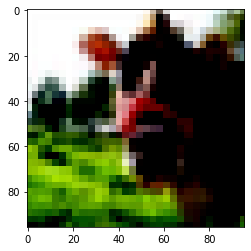

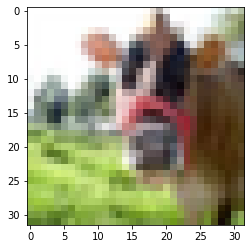

In [2]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(unprocessed_training_images[0])
plt.show()

Lets also take alook at a few of the examples from cifar100. This is a challenging dataset, the images are small and therefore low resolution, and some are pretty obscure—the 'cloud' and two 'sea' images below lack detail. The 'aquarium fish' and 'rose' and 'squirrel' are tough as well. 

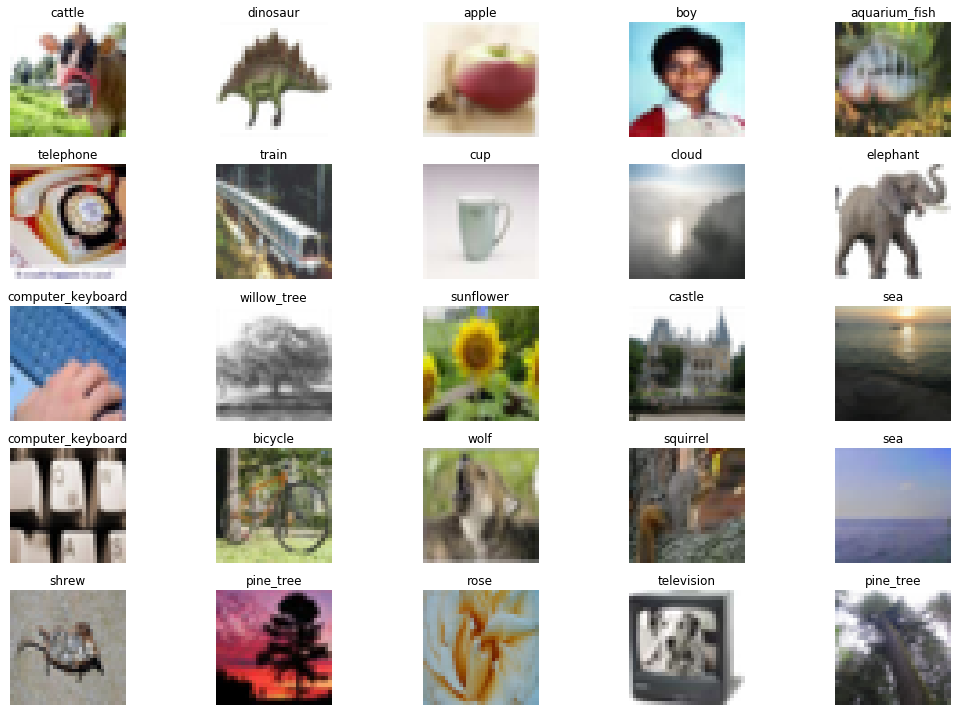

In [3]:
# Some of these are genuinely challenging... 
label_map = [
    'apple', # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm'
]

plt.figure(figsize=(15, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.axis('off')
    ax.set_title(label_map[unprocessed_training_labels[i][0]])
    plt.imshow(unprocessed_training_images[i])

plt.tight_layout()
plt.show()

In [4]:
# This should look familiar from previous labs.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

Lets quickly loook a little closer at MobileNetV2, so we can think carefully about which layers to freeze and how to apply transfer learning. 

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Layers go from 0-154
#   initial=0-9
#   block1 = 10-18
#   block2 = 19-27
#   block3 = 28-36
#   block4 = 37-45
#   block5 = 46-54
#   block6 = 55-63
#.  block7 = 64-72
#   block8 = 73-81
#.  block9 = 81-90
#   block10= 91-98
#   block11= 99-107
#.  block12= 108-116
#.  block13= 117-125
#   block14= 126-134
#.  block15= 135-143
#.  block16= 144-151
#.  final_conv = 152, 
#   conv_bn 153
#   out_relu = 154
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
base_model.summary()

9412608/9406464 [==============================] - 6s 1us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
_________________

# Transfer Learning Tips and Pitfalls

## Dataset considerations

In general terms there are two things to consider when deciding to try transfer learning:

* How much data do I have for my new task?
* How similar is the old task with the new task?

Depending on the answers to these questions we may want to apply different transfer tactics, including:

* Using the original network as a "feature extractor."
* Completely retraining the original network, but with the pre-trained weights as a starting point instead of random values.
* Fine tuning the original network by unfreezing only a portion of that network.
* Fine tuning the original network by iteratively unfreezing some layers, or applying different learning rates on each layer.

The more data we have for the new task, the more likely it is that we'll have success with retraining some or all of the original network. The more similar the tasks are, the more likely the transfer learning process will work. The more similar the tasks are, the more likely we are to have success without retraining the original layers.

Also note: When we have less data for the new task we may be forced to try transfer learning because we don't have enough data to fully train our a network from scratch. 

Although transfer learning can help us when we don't have a large dataset, the standard rule still applies: the more data we have for our task the better.

## Training considerations

Different hyperparameters can dramatically impact the effectiveness of transfer learning. Some combinations will be very effective, others will lead to overfitting, others won't learn anything at all. With transfer learning it is important to consider the similarity of the task being trained, as well as the amount of data available.

In general:

* Slower learning rates work better.
    * If the original network already has "good" weights for the new task, we should expect to need only minor adjustments.
    * If the original network doesn't already have "good" weights for the new task, we may as well be fully retraining from randomized weights.


## In the context of transfer from ImageNet -> Cifar100

* ImageNet is comprised of 1000 classes of high resolution images, Cifar is 100 classes at low resolution. 
* Some of the classes are similar between the two, but some classes from ImageNet have no equivilants in Cifar.
* Cifar itself is a pretty good size, with 60k images.

This makes Cifar an "okay" task for transfer learning from a network trained on ImageNet. Not the best candidate, but not the worst either.

# Tactic 1: Use the network as a feature extractor

In this example we will keep all the original weights frozen, and in fact we're going to use the MobileNet instance as a form of preprocessing to create a new set of training data with each datapoint now being the output of running that image through MobileNet.

In the second step, we'll build an ANN which serves as the classification head of our network which will take as input these "preprocessed" images and produce our class predictions as normal.

In [6]:
# The first way we'll do transfer learning REALLY saves time, but
# only works if you don't want to fine tune any of the layers 
# from the original network. What we can do instead is memorize
# the output of the base network, since it won't be changing,
# and then repeatedly train on those outputs and the training labels

# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Unlike before, we're going to just run the images through this base layer once
# This takes awhile, we're essentially doing a round of evaluation on both datasets.
# And we'll save them incase we want to experiment with different models to transfer
# on top of these.
training_features = base_model.predict(x_train)
np.savez('MobileNetV2_features_train', features=training_features)

test_features = base_model.predict(x_test)
np.savez('MobileNetV2_features_test', features=test_features)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 5s 117us/sample - loss: 2.9527 - accuracy: 0.2856 - val_loss: 2.0693 - val_accuracy: 0.4520
Epoch 2/20
40000/40000 [==============================] - 4s 106us/sample - loss: 2.1225 - accuracy: 0.4385 - val_loss: 1.8516 - val_accuracy: 0.5007
Epoch 3/20
40000/40000 [==============================] - 4s 104us/sample - loss: 1.8827 - accuracy: 0.4904 - val_loss: 1.7635 - val_accuracy: 0.5180
Epoch 4/20
40000/40000 [==============================] - 4s 101us/sample - loss: 1.7279 - accuracy: 0.5248 - val_loss: 1.7331 - val_accuracy: 0.5326
Epoch 5/20
40000/40000 [==============================] - 4s 106us/sample - loss: 1.6168 - accuracy: 0.5523 - val_loss: 1.7066 - val_accuracy: 0.5370
Epoch 6/20
40000/40000 [==============================] - 4s 107us/sample - loss: 1.5083 - accuracy: 0.5768 - val_loss: 1.6670 - val_accuracy: 0.5501
Epoch 7/20
40000/40000 [==========================

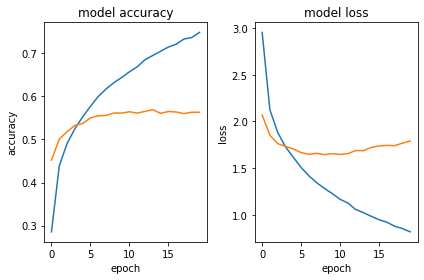

Test loss: 1.78
Test accuracy: 0.566


In [10]:
# If you have not run the above cell during this session, uncomment these lines to load the features.
# training_features = np.load('MobileNetV2_features_train.npz')['features']
# test_features = np.load('MobileNetV2_features_test.npz')['features']

# Also unlike before, we're going to build a complete model
# in the normal way, but define the input shape based on the 
# features predicted by base_model!
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=training_features.shape[1:]))

# Note from the summary, this will result in 1280 nodes, let's use the classic "squeeze" and add dropout
model.add(Dense(units=640, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(units=320, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_features, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=True)

plot_training_history(history, model)
loss, accuracy = model.evaluate(test_features, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Notes

It's worth noting that cifar100 is a very tricky dataset. The images are small, 100 classes is several, and 100 classes amongst rougly 60k examples is only on average 600 samples per class. In fact this 56% test accuracy would have put us in 4th place in a 2016 Kaggle competition. Obviously that's a few years back now... but MobileNetV2 and this 3 layer top isn't exactly "state of the art" either. It only took about 3 minutes to train this network on a commodity CPU. 

https://www.kaggle.com/c/ml2016-7-cifar-100/leaderboard

Boom, we're a top ten Kaggel competitor just like that. Though, looking at validation accuracy and loss, it's not clear we're going to improve much further, and clearly even with significant dropout we're overfitting. It may be worth trying to do transfer learning from a different pre-trained model.

# Tactic 2: Freezing Some Layers and Fine Tuning Others

An alternative tactic is to allow some portion of the original network to adjust its weights while freezing other portions. Typically, later layers are unfrozen and earlier layers are frozen. Often, the final convolutional layers are specific to the original task, and allowing them to retrain can help boost accuracy especially if we have a decent amount of training data.

For example, MobileNetV2 is split into 16 blocks. If we think the final few convolutional layers are too specific to the ImageNet benchmark then we can allow the weights in some of these blocks to retrain while keeping the weights in earlier layers fixed. This is called fine-tuning.

In [14]:
# One way to do transfer learning is called "fine tuning". This is where you take an existing network
# and freeze some of the layers. In addition to freezing some layers, you'll have to add at a minimum
# a new output layer that matches the number of classes for the new task. 

# Typically the earlier layers are frozen, because these are likely to have learned universal/simple features.
# The later layers have learned combinations of those features and are increasingly specific to the task
# that the network was trained for. 
def transfer_from_mobilenet(optimizer, freeze_first_n_layers, batch_size, epochs):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # We'll use the same "squeeze" w/ dropout structure from above...
    # We have to use the "functional" API now, which is why we're not using model.add
    old_top = base_model.output
    old_top = GlobalAveragePooling2D()(old_top)
    old_top = Dense(units=640, activation='relu')(old_top)
    old_top = Dropout(rate=0.4)(old_top)
    old_top = Dense(units=320, activation='relu')(old_top)
    old_top = Dropout(rate=0.2)(old_top)
    new_top = Dense(NUM_CLASSES, activation='softmax')(old_top)
    
    model = Model(inputs=base_model.input, outputs=new_top)

    # Setting a layer to trainable = False stops it from adjusting it's parameters (weights/biases)
    for layer in model.layers[:freeze_first_n_layers]:
        layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=True)
    
    return history, model

## Examples, Successes and Failures:

Here we're going to demonstrate a few different "fine-tuning" transfers with different numbers of frozen layers and different optimizers. Some more successful than others.

Transfer learning with sgd, 134 Will save as:  sgd_134.h5

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 331s 8ms/sample - loss: 4.2653 - accuracy: 0.0844 - val_loss: 4.0703 - val_accuracy: 0.1139
Epoch 2/5
40000/40000 [==============================] - 319s 8ms/sample - loss: 2.8076 - accuracy: 0.3186 - val_loss: 3.2642 - val_accuracy: 0.2404
Epoch 3/5
40000/40000 [==============================] - 316s 8ms/sample - loss: 2.1025 - accuracy: 0.4525 - val_loss: 3.1112 - val_accuracy: 0.2640
Epoch 4/5
40000/40000 [==============================] - 306s 8ms/sample - loss: 1.7899 - accuracy: 0.5204 - val_loss: 3.0310 - val_accuracy: 0.2856
Epoch 5/5
40000/40000 [==============================] - 310s 8ms/sample - loss: 1.5907 - accuracy: 0.5649 - val_loss: 3.0163 - val_accuracy: 0.2860


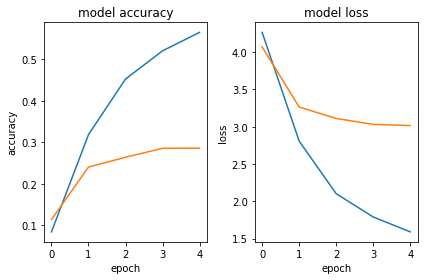

Test loss: 3.01
Test accuracy: 0.292
Transfer learning with sgd, 143 Will save as:  sgd_143.h5

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 314s 8ms/sample - loss: 4.2997 - accuracy: 0.0772 - val_loss: 4.1562 - val_accuracy: 0.1163
Epoch 2/5
40000/40000 [==============================] - 313s 8ms/sample - loss: 2.9598 - accuracy: 0.2925 - val_loss: 3.7121 - val_accuracy: 0.1834
Epoch 3/5
40000/40000 [==============================] - 308s 8ms/sample - loss: 2.2507 - accuracy: 0.4176 - val_loss: 3.5173 - val_accuracy: 0.2055
Epoch 4/5
40000/40000 [==============================] - 314s 8ms/sample - loss: 1.9260 - accuracy: 0.4882 - val_loss: 3.3816 - val_accuracy: 0.2294
Epoch 5/5
40000/40000 [==============================] - 320s 8ms/sample - loss: 1.7384 - accuracy: 0.5294 - val_loss: 3.3455 - val_accuracy: 0.2383


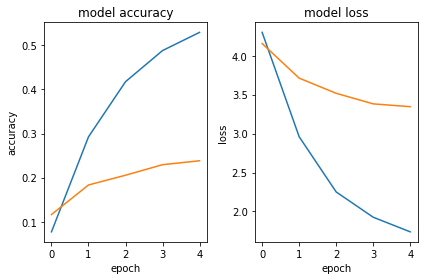

Test loss: 3.34
Test accuracy: 0.234
Transfer learning with <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x1450055d0>, 134 Will save as:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x1450055d0>_134.h5

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 347s 9ms/sample - loss: 3.5644 - accuracy: 0.2048 - val_loss: 3.6720 - val_accuracy: 0.1923
Epoch 2/5
40000/40000 [==============================] - 340s 8ms/sample - loss: 1.9743 - accuracy: 0.4882 - val_loss: 3.2574 - val_accuracy: 0.2538
Epoch 3/5
40000/40000 [==============================] - 328s 8ms/sample - loss: 1.5411 - accuracy: 0.5856 - val_loss: 3.1358 - val_accuracy: 0.2729
Epoch 4/5
40000/40000 [==============================] - 336s 8ms/sample - loss: 1.3056 - accuracy: 0.6422 - val_loss: 2.9784 - val_accuracy: 0.3023
Epoch 5/5
40000/40000 [==============================] - 308s 8ms/sample - loss: 1.1171 - accuracy: 0.6865 - val_loss: 3.066

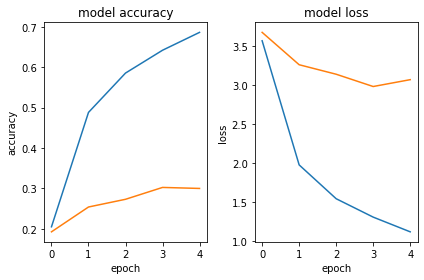

Test loss: 3.07
Test accuracy: 0.293
Transfer learning with <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x1450055d0>, 143 Will save as:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x1450055d0>_143.h5

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 292s 7ms/sample - loss: 2.5548 - accuracy: 0.3758 - val_loss: 3.5283 - val_accuracy: 0.2420
Epoch 2/5
40000/40000 [==============================] - 298s 7ms/sample - loss: 1.6084 - accuracy: 0.5657 - val_loss: 3.5689 - val_accuracy: 0.2573
Epoch 3/5
40000/40000 [==============================] - 304s 8ms/sample - loss: 1.3539 - accuracy: 0.6249 - val_loss: 3.3887 - val_accuracy: 0.2747
Epoch 4/5
40000/40000 [==============================] - 302s 8ms/sample - loss: 1.1834 - accuracy: 0.6632 - val_loss: 3.3174 - val_accuracy: 0.2810
Epoch 5/5
40000/40000 [==============================] - 298s 7ms/sample - loss: 1.0600 - accuracy: 0.6968 - val_loss: 3.461

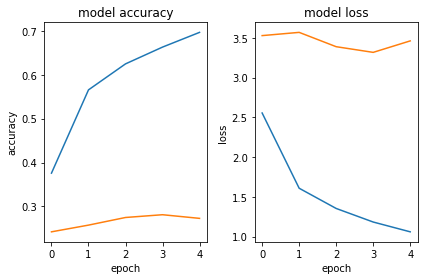

Test loss: 3.47
Test accuracy: 0.27


In [15]:
from itertools import product
from tensorflow.keras.optimizers import Adam
import os # for saving with paths. 

# These experiments took *several hours* to run originally.
# Saving the model after an experiment is a good idea, then you
# can experiment further with promising models, without rerunning
# entier experiments.
save_directory = 'saved_models'

# More agressive optimizers like adam can result in overfitting
# We should watch for that in our results.
optimizers = [
    'sgd',
    Adam(lr=0.0001)  # Slower than normal learning rate. 
]

# Note: experimentally freezing only the first 2 blocks
# resulted in much slower performance, though for SGD freezing 
# only the first block did achieve 50% accuracy on test data 
freeze_layer_counts = [
    134,   # Up through block 14 frozen
    143    # Up through block 15 frozen
    
    # If we were to set a value here to 154, it would freeze all the original layers
    # which can be quite successful, but we can make training much faster using a 
    # different tactic to freeze all the original layers as demonstrated above
]

# This takes a LOOOOONNNNNNNGGGGG time, don't re-run it unless you're prepared to wait. 
for optimizer, freeze_first_n_layers in product(optimizers, freeze_layer_counts):
    saved_name = f'{optimizer}_{freeze_first_n_layers}.h5'
    print(f'Transfer learning with {optimizer}, {freeze_first_n_layers}', "Will save as: ", saved_name)
    print()

    history, model = transfer_from_mobilenet(optimizer, freeze_first_n_layers, 128, 5)
    model.save(os.path.join(save_directory, saved_name))
    plot_training_history(history, model)
    
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    

## Four "Okay" Results: Micro-exercise

In pairs, discuss reasons that these transfers don't seem to be very successful.

### A few considerations:

None of these first four combinations are better than our "feature extractor" tactic. There are two things to consider:

* Perhaps we're unfreezing too many layers?
    * Or not enough?
* Perhaps we're using a too-agressive optimizer and losing the value from ImageNet by "forgetting" the original weights too quickly.
    * I don't think we could be learning "too slow" though... why not?
* It can always be a combination of factors...

## Lets Try Freezing Less

Lets try an agressive optimizer with only the last 2 convolutional layers unfrozen.

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 284s 7ms/sample - loss: 2.4848 - accuracy: 0.3901 - val_loss: 3.5059 - val_accuracy: 0.2351
Epoch 2/5
40000/40000 [==============================] - 279s 7ms/sample - loss: 1.5971 - accuracy: 0.5688 - val_loss: 3.3056 - val_accuracy: 0.2609
Epoch 3/5
40000/40000 [==============================] - 296s 7ms/sample - loss: 1.3392 - accuracy: 0.6256 - val_loss: 3.4534 - val_accuracy: 0.2635
Epoch 4/5
40000/40000 [==============================] - 279s 7ms/sample - loss: 1.1499 - accuracy: 0.6709 - val_loss: 4.0231 - val_accuracy: 0.2381
Epoch 5/5
40000/40000 [==============================] - 285s 7ms/sample - loss: 1.0005 - accuracy: 0.7093 - val_loss: 3.8136 - val_accuracy: 0.2594


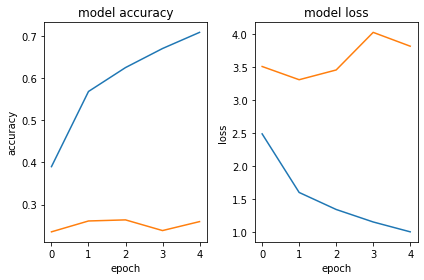

Test loss: 3.84
Test accuracy: 0.255


In [16]:
history, model = transfer_from_mobilenet('adam', 151, 128, 5)
model.save(os.path.join(save_directory, saved_name))
plot_training_history(history, model)

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

### Still not great, lets try unfreezing MORE

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 790s 20ms/sample - loss: 2.4210 - accuracy: 0.3914 - val_loss: 7.8928 - val_accuracy: 0.0157
Epoch 2/5
40000/40000 [==============================] - 781s 20ms/sample - loss: 1.5454 - accuracy: 0.5875 - val_loss: 7.0846 - val_accuracy: 0.0205
Epoch 3/5
40000/40000 [==============================] - 807s 20ms/sample - loss: 1.2732 - accuracy: 0.6531 - val_loss: 6.6283 - val_accuracy: 0.0151
Epoch 4/5
40000/40000 [==============================] - 790s 20ms/sample - loss: 1.1043 - accuracy: 0.6931 - val_loss: 7.0993 - val_accuracy: 0.0331
Epoch 5/5
40000/40000 [==============================] - 792s 20ms/sample - loss: 0.9759 - accuracy: 0.7267 - val_loss: 5.0560 - val_accuracy: 0.0637


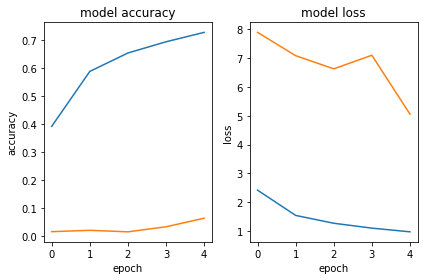

In [17]:
# lets try unfreezing a lot more. We have a reasonable amount of training data, so lets try!

# WARNING, THIS TOOK ~2 hours on my MacbookPro
history, model = transfer_from_mobilenet('adam', 0, 128, 5) # unfreeze it all!
plot_training_history(history, model)
model.save(os.path.join(save_directory, "adam_train_all.h5"))

## Even worse!

We overfit extremely early and thereafter made very little progress on our validation scores. Brutal.

### Micro-exercise, discuss

Why do we think this result occured? Is it the amount we unfroze? Is it the training tactics? Is it both? 

## Lets slow down the learning rate

In the next sample we still unfreeze everything, but we use a much slower learning rate with SGD (10x slower than the default value).

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 724s 18ms/sample - loss: 4.9200 - accuracy: 0.0125 - val_loss: 4.6830 - val_accuracy: 0.0119
Epoch 2/5
40000/40000 [==============================] - 720s 18ms/sample - loss: 4.6629 - accuracy: 0.0195 - val_loss: 4.5614 - val_accuracy: 0.0241
Epoch 3/5
40000/40000 [==============================] - 717s 18ms/sample - loss: 4.4994 - accuracy: 0.0335 - val_loss: 4.4482 - val_accuracy: 0.0486
Epoch 4/5
40000/40000 [==============================] - 717s 18ms/sample - loss: 4.3510 - accuracy: 0.0586 - val_loss: 4.2846 - val_accuracy: 0.1031
Epoch 5/5
40000/40000 [==============================] - 722s 18ms/sample - loss: 4.1490 - accuracy: 0.0995 - val_loss: 4.0376 - val_accuracy: 0.1710


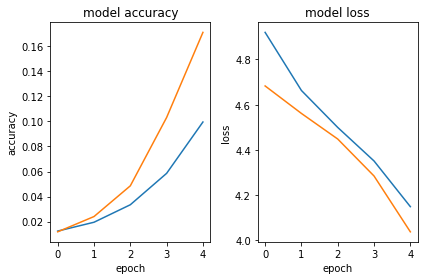

In [27]:
# Lets slow down the learning rate to try and avoid overfitting so fast.

history, model = transfer_from_mobilenet(SGD(learning_rate=0.001), 0, 128, 5) # unfreeze it all!
plot_training_history(history, model)
model.save(os.path.join(save_directory, "SDG_train_all_slow.h5"))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 732s 18ms/sample - loss: 3.7127 - accuracy: 0.1872 - val_loss: 3.4814 - val_accuracy: 0.2724
Epoch 2/10
40000/40000 [==============================] - 721s 18ms/sample - loss: 3.4166 - accuracy: 0.2386 - val_loss: 3.0787 - val_accuracy: 0.3426
Epoch 3/10
40000/40000 [==============================] - 744s 19ms/sample - loss: 3.1241 - accuracy: 0.2939 - val_loss: 2.7560 - val_accuracy: 0.3978
Epoch 4/10
40000/40000 [==============================] - 753s 19ms/sample - loss: 2.8458 - accuracy: 0.3428 - val_loss: 2.4493 - val_accuracy: 0.4472
Epoch 5/10
40000/40000 [==============================] - 783s 20ms/sample - loss: 2.5980 - accuracy: 0.3812 - val_loss: 2.1879 - val_accuracy: 0.4903
Epoch 6/10
40000/40000 [==============================] - 711s 18ms/sample - loss: 2.3879 - accuracy: 0.4154 - val_loss: 1.9617 - val_accuracy: 0.5309
Epoch 7/10
40000/40000 [====================

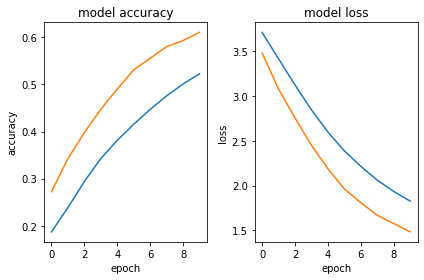

In [30]:
# Okay, that actually looks quite encouraging, if a bit slow... lets train it some more!
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=True)
plot_training_history(history, model)
model.save(os.path.join(save_directory, "SDG_train_all_slow_further.h5"))

## Notes:

This worked much better overall, and actually outperformed our "feature extraction" tactic without overfitting the data! Note only that, but based on this curve and the fact that the validation scores are **better** than the training scores we could probably continue to train at this rate and get even better results.

However, we did have to train for much longer (more epochs and MUCH more compute time), which in some sense defeats the purpose of transfer learning. We could find out if that's the case by applying the exact same training regime to a randomly initialized version of MobileNet rather than a pretrained version. Consider that an exercise to try... :)

# Summary of Results so Far:

Slow and steady wins the race this time around. Based on the curve, and lack of overfitting we could probably continue to train this final model for several more epochs and continue to see improvements. I'll leave that as an exercise for your GPU.

Taken together, the above experiments suggest fine tuning isn't working out for these two data sets and MobileNetV2. We got the best results from freezing the whole thing, or retraining the whole thing (but only when we train slowly!!). With fine tuning and a totally frozen pretrained network we ended up overfitting by a lot. 

All in all, this is about what we expected. CIFAR and ImageNet really are not that similar, and with CIFAR we do have enough data to justify training the whole network. Starting with pretrained weights has been showen to generally improve the speed of reaching high performance, and this is something else you could easily test in this case with slight modifications to the above code.

**We need to experiment with fine tuning at a much lower learning rate with plain SGD to fully validate our hypothesis.** A slow rate worked very will with the full network unfrozen, but it might also work well with fine tuning. On the other hand, the more agressive `adam` performed horribly in both fine tuning and training the whole network.


# Additional Things To Note:

This could be a good time to apply data augmentation to synthetically increase our dataset and make the task harder for the network to memorize, both to reduce overfitting and supply more training data. 

When fine tuning, the "classification head" is working with an ever changing feature extractor, rather than the fixed target. Additionally, there are many more parameters being changed and more gradients being propogated backwards. This can slow convergance and also contribute to the overfitting we observed compared to using a pretrained network as a feature extractor.

The relationship between the layers is complex and fairly inscrutable. When we change the weights of the final layers without allowing the weights at the early layers to also update accordingly we are changing the relationships between the layers, which might cause degraded performance if a tight relationship between layers has been learned.

Fine tuning can increase the network's capacity and propensity to overfit. We saw that in nearly all of these examples. Using slower learning rates and less agressive optimizers can help. 

In all our experiemnts (even the feature extraction one) we quickly began overfitting, and after that our optimizations only improved results on the training set... Once our network started down the path of "memorizing" the training data, it never recovered. Early stopping can save you from wasteful training sessions.

Fine tuning works best when the underlying datasets are more similar. CIFAR100 and ImageNet are only kind of similar, the difference in image resolution could be playing a large role here. It's possible that starting with MobileNetv2 from scratch and NOT transfer learning would result in better outcomes, since the CIFAR100 dataset is relatively large.

The dense layers in our classifier ALSO contribute to this model's ability to overfit. Sometimes a classifier with less capacity can improve the results, for example simply using a GlobalAveragePooling layer and feeding that directly into the final classifier can yield better results. 

All together, this can help account for why using MobileNet as a feature extractor performed better overall than most of our fine tuning efforts. Fine tuning is a great tool, but it may not always yield the best results. In our case, starting with pretrained weights and then retraining the WHOLE network with a very slow learning rate earned the best overall performance.

Remember to experiment with multiple tactics!

Lets try one last experiment still, before we decide that fine-tuning from ImageNet to CIFAR100 on MobileNetV2 is not the way to go...

# Tactic 3: Discriminative Fine Tuning

In addition to freezing a fixed set of layers, you can iteratively unfreeze more and more layers. That is: Train the last 10 layers for a few epochs, then train the final 20 layers for some more epochs, then the final 30 layers for a few more epochs, and so on.

This is a reminder that it isn't just the model that needs careful engineering: the training process should be carefully crafted as well. In the below code samples we show two (very similar) examples of this discriminative fine tuning. Consider playing with the parameters below as well to achieve better performance. Notice I used a higher learning rate than in the most successful experiment above... perhaps a slower one will perform better!

In [34]:
def discriminative_fine_tuning(model, optimizer, layer_unfreeze_points, epochs_per_freeze_point, batch_size):
    # All histories returned for more holistic visualiation after the fact.
    all_histories = []
    
    # Intially freeze everything, we'll unfreeze layers iteratively as we train
    for layer in model.layers:
        layer.trainable = False
    
    # Caller specifies blocks of layers to unfreeze at once
    for current_unfreeze_point in layer_unfreeze_points:
        
        # Unfreeze everything after the current freeze point
        print("Unfreezing layers after: ", current_unfreeze_point)
        for layer in model.layers[current_unfreeze_point:]:
            layer.trainable = True
        
        # Must compile after freezing/unfreezing or the changes won't be applied
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train at each unfreeze point
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs_per_freeze_point, validation_split=0.2, verbose=True)
        all_histories.append(history)
    
    return all_histories, model


def plot_combined_histories(all_histories):
    # Some code to plot all the histories at once...
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    # Simply cobble together the individual histories
    for history in all_histories:
        acc.extend(history.history['accuracy'])
        val_acc.extend(history.history['val_accuracy'])
        loss.extend(history.history['loss'])
        val_loss.extend(history.history['val_loss'])

    # And plot them the same way as the function at the top of this notebook.
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

In [22]:
from tensorflow.keras.optimizers import SGD

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# We'll use the same "squeeze" w/ dropout structure from above...
# We have to use the "functional" API now, which is why we're not using model.add
old_top = base_model.output
old_top = GlobalAveragePooling2D()(old_top)
old_top = Dense(units=640, activation='relu')(old_top)
old_top = Dropout(rate=0.4)(old_top)
old_top = Dense(units=320, activation='relu')(old_top)
old_top = Dropout(rate=0.2)(old_top)
new_top = Dense(NUM_CLASSES, activation='softmax')(old_top)

model = Model(inputs=base_model.input, outputs=new_top)

# These points were carefully chosen based on the model.
# Specifially, each convolutional bottleneck block is unfrozen as a whole
# Note: Descending order is required for the above funtion to work as expected
layer_unfreeze_points = [
    154, # First, just train the new top
    144, # The final conv, and the final full block
    126, # After this we're unfreezing 2 blocks at a time
    108,
    91,
    73,
    55,
    37,
    19
]

# Note, 2x slower than the default learning rate
opt = SGD(learning_rate=0.005)

# Note: Even at 1 epoch per unfreeze point, we're training for twice as many epochs as the above (5 vs 9)
all_histories, model = discriminative_fine_tuning(model, opt, layer_unfreeze_points, 1, 128)
model.save(os.path.join(save_directory, "discriminative_full_one_epoch.h5"))
plot_combined_histories(all_histories)

Unfreezing layers after:  154
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 278s 7ms/sample - loss: 4.7438 - accuracy: 0.0161 - val_loss: 4.6045 - val_accuracy: 0.0218
Unfreezing layers after:  144
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 296s 7ms/sample - loss: 4.4093 - accuracy: 0.0565 - val_loss: 4.3743 - val_accuracy: 0.0691
Unfreezing layers after:  126
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 319s 8ms/sample - loss: 3.7325 - accuracy: 0.1787 - val_loss: 3.9526 - val_accuracy: 0.1269
Unfreezing layers after:  108
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 390s 10ms/sample - loss: 2.8413 - accuracy: 0.3263 - val_loss: 3.7912 - val_accuracy: 0.1707
Unfreezing layers after:  91
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================]

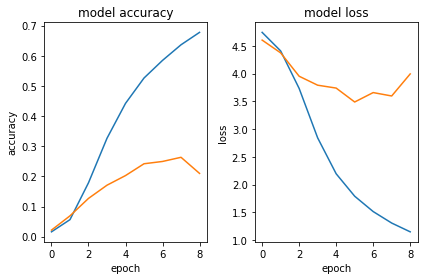

In [24]:
# Possibly still too fast, possibly too much unfreezing, possibly fine tuning is not a great fit
# for this problem/setup (MobileNetV2 ImageNet -> CIFAR100).

In [32]:
# The same experiment with a lower capacity classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# We'll use the same "squeeze" w/ dropout structure from above...
# We have to use the "functional" API now, which is why we're not using model.add
old_top = base_model.output
old_top = GlobalAveragePooling2D()(old_top)
old_top = Dense(units=640, activation='relu')(old_top)
old_top = Dropout(rate=0.4)(old_top)
old_top = Dense(units=320, activation='relu')(old_top)
old_top = Dropout(rate=0.2)(old_top)
new_top = Dense(NUM_CLASSES, activation='softmax')(old_top)

model = Model(inputs=base_model.input, outputs=new_top)

# These points were carefully chosen based on the model.
# Specifially, each convolutional bottleneck block is unfrozen as a whole
# Note: Descending order is required for the above funtion to work as expected
layer_unfreeze_points = [
    154, # First, just train the new top
    144, # The final conv, and the final full block
    126, # After this we're unfreezing 2 blocks at a time
    108
]

# Note, 10x slower than default
opt = SGD(learning_rate=0.001)
all_histories, model = discriminative_fine_tuning(model, opt, layer_unfreeze_points, 2, 128)
model.save(os.path.join(save_directory, "discriminative_half_two_epoch.h5"))

plot_combined_histories(all_histories)

Unfreezing layers after:  154
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 308s 8ms/sample - loss: 4.9493 - accuracy: 0.0099 - val_loss: 4.7340 - val_accuracy: 0.0086
Epoch 2/2
40000/40000 [==============================] - 282s 7ms/sample - loss: 4.7790 - accuracy: 0.0119 - val_loss: 4.6724 - val_accuracy: 0.0097
Unfreezing layers after:  144
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 287s 7ms/sample - loss: 4.6780 - accuracy: 0.0170 - val_loss: 4.6144 - val_accuracy: 0.0158
Epoch 2/2
40000/40000 [==============================] - 285s 7ms/sample - loss: 4.5771 - accuracy: 0.0238 - val_loss: 4.5702 - val_accuracy: 0.0250
Unfreezing layers after:  126
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 306s 8ms/sample - loss: 4.4815 - accuracy: 0.0367 - val_loss: 4.5234 - val_accuracy: 0.0403
Epoch 2/2
40000

NameError: name 'plot_combined_histories' is not defined

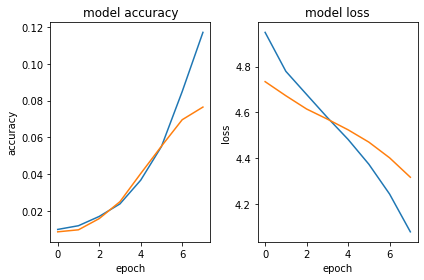

In [35]:
# Ignore that error message... I didn't want to re-run the training after adding the function.
# This is part of the joy (and horror) of working in Jupyter notebooks.

plot_combined_histories(all_histories)

This looks good enough to train more... We could try more epochs at each unfreezing stage and/or unfreezing more layers. This also seems to confirm our idea that a **slow learning rate** is critical to our success with this particular setup. (This tends to be true in transfer learning generally!) But note, this is 8 epochs to get to 11% training accuracy and 7.6% validation accuracy. Plus, it looks like it might be on the way to overfitting. 

Earlier when we unfroze all layers and trained after 8 epochs we ended up at ~29% training accuracy and 40% validation accuracy (!!) so this might also serve as further proof that fine tuning is not going to perform as well as just using the ImageNet weights as a starting point and re-training the whole network. 

# One Last Experiment — Learning Rate Decay

This is similar to the last experiment, except each time we unfreeze any more layers we slow the learning rate to 90% of whatever it was previously. We still iteratively unfreeze, but we start with a higher learning rate (.005) and decay it as time goes on. The idea is to reduce learning as we increase the parameter count to further avoid overfitting. 

In [36]:
def discriminative_fine_tuning_decay(model, layer_unfreeze_points, epochs_per_freeze_point, batch_size, lr=.005):
    # All histories returned for more holistic visualiation after the fact.
    all_histories = []
    
    # Intially freeze everything, we'll unfreeze layers iteratively as we train
    for layer in model.layers:
        layer.trainable = False
    
    # Caller specifies blocks of layers to unfreeze at once
    for current_unfreeze_point in layer_unfreeze_points:
        
        # Unfreeze everything after the current freeze point
        print("Unfreezing layers after: ", current_unfreeze_point)
        for layer in model.layers[current_unfreeze_point:]:
            layer.trainable = True
        
        # Must compile after freezing/unfreezing or the changes won't be applied
        print("Learning Rate: ", lr)
        optimizer = SGD(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        lr *= 0.90
        
        # Train at each unfreeze point
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs_per_freeze_point, validation_split=0.2, verbose=True)
        all_histories.append(history)
    
    return all_histories, model

Unfreezing layers after:  154
Learning Rate:  0.005
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 280s 7ms/sample - loss: 4.8195 - accuracy: 0.0119 - val_loss: 4.6026 - val_accuracy: 0.0176
Epoch 2/2
40000/40000 [==============================] - 266s 7ms/sample - loss: 4.5964 - accuracy: 0.0224 - val_loss: 4.5570 - val_accuracy: 0.0286
Unfreezing layers after:  144
Learning Rate:  0.0045000000000000005
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 290s 7ms/sample - loss: 4.4396 - accuracy: 0.0437 - val_loss: 4.4292 - val_accuracy: 0.0703
Epoch 2/2
40000/40000 [==============================] - 287s 7ms/sample - loss: 4.1271 - accuracy: 0.1052 - val_loss: 4.1667 - val_accuracy: 0.1077
Unfreezing layers after:  126
Learning Rate:  0.004050000000000001
Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 314s 8ms/s

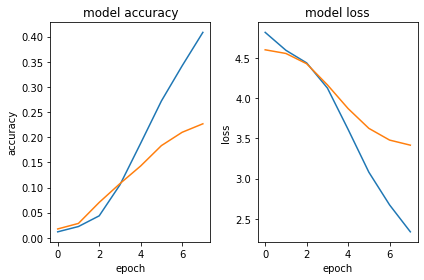

In [37]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

old_top = base_model.output
old_top = GlobalAveragePooling2D()(old_top)
old_top = Dense(units=640, activation='relu')(old_top)
old_top = Dropout(rate=0.4)(old_top)
old_top = Dense(units=320, activation='relu')(old_top)
old_top = Dropout(rate=0.4)(old_top)
new_top = Dense(NUM_CLASSES, activation='softmax')(old_top)

model = Model(inputs=base_model.input, outputs=new_top)

# These points were carefully chosen based on the model.
# Specifially, each convolutional bottleneck block is unfrozen as a whole
# Note: Descending order is required for the above funtion to work as expected
layer_unfreeze_points = [
    154, 
    144, 
    126, 
    108
]

# Some changes here...
all_histories, model = discriminative_fine_tuning_decay(model, layer_unfreeze_points, 2, 128)
model.save(os.path.join(save_directory, "discriminative_half_decay_two_epoch.h5"))
plot_combined_histories(all_histories)

This looks fine, overall the tactic even looks promising. It might be worth experimenting with different learning rates and decay rates/strategies... but the results are still not as good as just retraining the whole network with a slow learning rate. Cest la vie. 

# A Reminder: Don't Over Generalize These Results!

This is just one set of experiments with two datasets (CIFRA100 and ImageNet). The results we found here will not hold for all combinations of datasets — consider applying many of these in  your own research and be flexible about what might work well or poorly!

## Also keep in mind:

The fine-tuning and discriminative fine-tuning methods presented here are a bit crude compared to state of the art methods which can control more details such as adjusting the learning rate on a per-layer basis, and less simplistic methods of decreasing the learning rate over time.

# Smallish Exercise

Attempt one variety of transfer learning from ImageNet -> Cifar with a different built in network architecture such as Xception or ResNet50... You can do any of the 3 tactics applied here. FWIW Fully retraining a network is the most straightforward to implement.


In [ ]:
# Your code here